# OpenSoundscape Audio Read and spectrogram generate
- Exploratory notebook to develop a method to read .flac .wav and .mp3 audio files from disk and make spectrograms with default settings from these files. 
- Audio files will also be linked to a pandas dataframe. 
- Audio files will be cropped or looped to 3 seconds or other chosen duration

<br><br>

To Do:
- Load all of the clips and look at their lengths. 
- Create a batch of spectrograms saved to disk
- re-scale the spectrograms so that the frequency scale is centered on and bounded by the typical vocalization freq of the olive sided flycatcher. This doesn't need implementing until after first model is run. 
- Check that all the OSFL clips in the downloaded spectrograms match the clip id's of the osfls database. 

In [3]:
from pathlib import Path
from opensoundscape import Audio, Spectrogram
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import re

In [4]:
!pwd

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory


Set relative paths. 

In [5]:
data_path = Path('../../data/')
audio_read_path = Path('../../data/raw/recordings/')
image_save_path = Path('../../data/processed/img/osfls')
audio_save_path = Path('../../data/processed/audio/')

In [6]:
!mkdir $image_save_path

mkdir: ../../data/processed/img/osfls: File exists


# Load processed dataframe. 

In [7]:
df = pd.read_pickle(data_path/'processed/processed_metadata.pkl')

In [8]:
df.head()

,clip_id,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,...,right_freq_filter_tag_min_level,right_freq_filter_tag_max_level,right_freq_filter_tag_peak_level_dbfs,tagged_in_wildtrax,url,tag_spectrogram_url,clip_url,sensorId,tasks,status
0,0,BU,Alberta Archetypes,1501,BBS-4139-20,87850,2021-07-03 06:56:02,331758,None,595843,...,NaN,NaN,NaN,f,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,357,Active
1,1,BU,Alberta Archetypes,1501,BBS-4139-27,87844,2021-07-03 07:42:01,331765,None,595844,...,NaN,NaN,NaN,f,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,357,Active
2,2,BU,Alberta Archetypes,1501,BBS-4139-28,87842,2021-07-03 07:47:01,331764,None,595845,...,NaN,NaN,NaN,f,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,357,Active
3,3,BU,Alberta Archetypes,1501,BBS-4139-28,87842,2021-07-03 07:47:01,331764,None,595845,...,NaN,NaN,NaN,f,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,357,Active
4,4,BU,Alberta Archetypes,1501,BBS-4139-36,87834,2022-06-26 08:24:04,358620,None,595846,...,NaN,NaN,NaN,f,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,357,Active


In [10]:
osfls = pd.read_pickle(data_path/'processed/osfls')

In [11]:
audio_files = glob(str(audio_read_path)+'/*')
audio_files[:10], len(audio_files)

(['../../data/raw/recordings/recording-552428-clip-648452.flac',
  '../../data/raw/recordings/recording-552659-clip-666294.flac',
  '../../data/raw/recordings/recording-521417-clip-1023589.flac',
  '../../data/raw/recordings/recording-555929-clip-671299.flac',
  '../../data/raw/recordings/recording-292764-clip-591608.mp3',
  '../../data/raw/recordings/recording-296697-clip-614282.mp3',
  '../../data/raw/recordings/recording-255457-clip-7987.mp3',
  '../../data/raw/recordings/recording-553989-clip-695789.flac',
  '../../data/raw/recordings/recording-100175-clip-352185.mp3',
  '../../data/raw/recordings/recording-292108-clip-616235.mp3'],
 5163)

## A quick exploration of the opensoundscape audio / spec tutorial on flac and mp3
flac first

In [12]:
image_shape = (224,224)

In [13]:
audio = Audio.from_file(audio_files[2])

In [14]:
audio

<Audio(samples=(88800,), sample_rate=32000)>

In [15]:
spec = Spectrogram.from_audio(audio)

In [16]:
image = spec.to_image(shape=image_shape, invert=True)

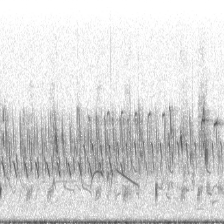

In [17]:
image

Great we can see a spectrogram with default settings. 

Turn this into a function then try on an mp3. 

In [18]:
audio_files[2]

'../../data/raw/recordings/recording-521417-clip-1023589.flac'

In [19]:
def show_spec_from_audio(file_path):
    audio = Audio.from_file(file_path)
    spec = Spectrogram.from_audio(audio)
    image = spec.to_image(shape=image_shape, invert=True)
    return image

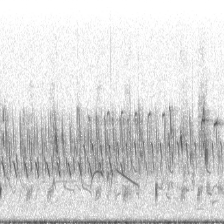

In [21]:
show_spec_from_audio(audio_files[2])

Great, it works on mp3s too. 

# Generate multiuple spectrograms
The spectrograms need to all end up being the same dimensions. 

Here are some parameters used by the funcitons below. 

In [25]:
clip_length = 3.0      # final duration of processed audio clips. 
spec_shape = (224,224) # output dimensions of spectrograms in pixels

In [26]:
audio_files = glob('../../data/raw/recordings/*')
audio_files[0]

'../../data/raw/recordings/recording-552428-clip-648452.flac'

In [27]:
first_10 = audio_files[:10]

# Trim the audio to 3s length or loop the sample
using crop off the end or concatenation of the start onto the end until the length is achieved

In [28]:
def resize_clip(audio_file, clip_length):
# Resize audio file to chosen clip length (seconds)

    audio = Audio.from_file(audio_file)

    if audio.duration < clip_length:
        audio = audio.loop(clip_length)
    elif audio.duration > clip_length:
        audio = audio.extend_to(clip_length)
    elif audio.duration == clip_length:
        pass

    return audio

clip = resize_clip(audio_files[6], clip_length)
clip

<Audio(samples=(132300,), sample_rate=44100)>

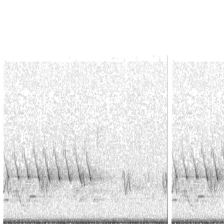

In [29]:
def make_uniform_spectrogram(audio_file, clip_length=clip_length, image_shape=image_shape):
    # Make spectrograms from equal duration clips.
    clip = resize_clip(audio_file, clip_length)
    spec =  Spectrogram.from_audio(clip)
    image = spec.to_image(shape=image_shape, invert=True)
    return image

image = make_uniform_spectrogram(audio_files[8], clip_length=3.0)
image

# There are some artefacts present in the looped spectrograms.
 - a solid vertical bar indicates a 'pop' due to cutting at a non zero crossing. 
 - the vertical white bar is silence at the start of the recording. 
 Windowing, and cutting the audio at zero crossings, will help here. 

# Save multiple spectrograms

In [30]:
def exists(file):
    return Path(file).exists()

In [31]:
def make_and_save_specs(audio_files, clip_length=clip_length, image_shape=image_shape):
    exceptions = 0
    skipped = 0
    for audio_file in audio_files:
        try:
            image = make_uniform_spectrogram(audio_file, clip_length, image_shape)
        except :
            print(f'could not read file {audio_file}')
            exceptions += 1
        else: 
            # save the spectrogram if it hasn't been saved already. 
            fname = re.sub('\.[\w]+', '.png', (Path(audio_file).name))
            if exists(image_save_path.joinpath(fname)):
                skipped += 1
            else:
                image.save(image_save_path.joinpath(fname), format='png')
                
    print(f'finished making spectrograms. Skipped {skipped} with {exceptions} exceptions')
    
make_and_save_specs(audio_files[:1000])

<>:12: DeprecationWarning: invalid escape sequence '\.'
<>:12: DeprecationWarning: invalid escape sequence '\.'
/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_22111/2932968416.py:12: DeprecationWarning: invalid escape sequence '\.'
  fname = re.sub('\.[\w]+', '.png', (Path(audio_file).name))
/opt/homebrew/lib/python3.10/site-packages/opensoundscape/audio.py:1329: UserWarning: Failed to load metadata: argument of type 'NoneType' is not iterable. Metadata will be None
  warnings.warn(f"Failed to load metadata: {exc}. Metadata will be None")


could not read file ../../data/raw/recordings/recording-255544-clip-8040.flac
finished making spectrograms. Skipped 999 with 1 exceptions


In [39]:
osfls

,clip_id,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,...,right_freq_filter_tag_peak_level_dbfs,tagged_in_wildtrax,url,tag_spectrogram_url,clip_url,sensorId,tasks,status,clip_index,file_type
3646,3646,BU,ARU Test Project Model Comparisons 2021,1099,ATP-FLB-14A,238593,2021-06-28 06:00:00,366621,1SPM,343288,...,-49.89,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,212,Active,3646,mp3
3696,3696,BU,ARU Test Project Model Comparisons 2021,1099,ATP-FLB-14A,238593,2021-07-02 05:00:00,366633,1SPM,343300,...,-51.82,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,212,Active,3696,mp3
3740,3740,BU,ARU Test Project Model Comparisons 2021,1099,ATP-FLB-14A,238593,2021-07-02 06:00:00,366638,1SPM,343305,...,-50.75,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,212,Active,3740,mp3
3759,3759,BU,ARU Test Project Model Comparisons 2021,1099,ATP-FLB-14B,238600,2021-06-28 05:00:00,366610,1SPM,343277,...,-35.09,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,212,Active,3759,mp3
3877,3877,BU,ARU Test Project Model Comparisons 2021,1099,ATP-FLB-14B,238600,2021-07-02 05:00:00,366631,1SPM,343298,...,NaN,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,https://wildtrax-aru.s3.us-west-2.amazonaws.co...,ARU,212,Active,3877,flac
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150017,1150017,CWS-NOR,YT High Elevation Monitoring Program CWS North...,828,YTHEMP-YSL-261611-H2,180780,2021-06-26 06:15:00,280349,1SPT,257087,...,-54.28,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,ARU,1128,Published - Public,1150017,mp3
1150702,1150702,CWS-NOR,YT High Elevation Monitoring Program CWS North...,828,YTHEMP-YSL-266936-S2,181109,2021-06-19 07:15:00,282767,1SPT,261691,...,-59.14,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,ARU,1128,Published - Public,1150702,mp3
1150710,1150710,CWS-NOR,YT High Elevation Monitoring Program CWS North...,828,YTHEMP-YSL-266936-S2,181109,2021-06-21 05:30:00,282763,1SPT,261687,...,-57.87,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,ARU,1128,Published - Public,1150710,mp3
1150755,1150755,CWS-NOR,YT High Elevation Monitoring Program CWS North...,828,YTHEMP-YSL-266936-S3,181110,2021-06-19 04:30:00,282759,1SPT,261683,...,-54.66,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,ARU,1128,Published - Public,1150755,mp3


In [51]:
saved_images = glob(str(image_save_path)+'/*')

In [52]:
saved_images

['../../data/processed/img/osfls/recording-555108-clip-659628.png',
 '../../data/processed/img/osfls/recording-816068-clip-892387.png',
 '../../data/processed/img/osfls/recording-557153-clip-698926.png',
 '../../data/processed/img/osfls/recording-538791-clip-700521.png',
 '../../data/processed/img/osfls/recording-556084-clip-673853.png',
 '../../data/processed/img/osfls/recording-575976-clip-719481.png',
 '../../data/processed/img/osfls/recording-555805-clip-669504.png',
 '../../data/processed/img/osfls/recording-555623-clip-666646.png',
 '../../data/processed/img/osfls/recording-556206-clip-676183.png',
 '../../data/processed/img/osfls/recording-553790-clip-680130.png',
 '../../data/processed/img/osfls/recording-553980-clip-695309.png',
 '../../data/processed/img/osfls/recording-622365-clip-725426.png',
 '../../data/processed/img/osfls/recording-552695-clip-669224.png',
 '../../data/processed/img/osfls/recording-487913-clip-764767.png',
 '../../data/processed/img/osfls/recording-57783

In [57]:
osfls.loc[osfls.clip_id == 698233]

,clip_id,organization,project,project_id,location,location_id,recording_date_time,recording_id,task_method,task_id,...,right_freq_filter_tag_peak_level_dbfs,tagged_in_wildtrax,url,tag_spectrogram_url,clip_url,sensorId,tasks,status,clip_index,file_type
698233,698233,CWS-ONT,CWS-Ontario Boreal Shield-Lowlands Transition ...,1310,Q640-2,336753,2022-06-07 06:22:00,557122,1SPT,515430,...,NaN,t,https://portal.wildtrax.ca/home/aru-tasks/reco...,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,https://wildtrax-aru-ca.s3.ca-central-1.amazon...,ARU,8060,Published - Public,698233,flac
